# Sankey flow diagram

In [1]:
import os
from pathlib import Path

from category_encoders import OrdinalEncoder
import numpy as np
import pandas as pd
from plotly.offline import init_notebook_mode, iplot

In [2]:
init_notebook_mode(connected=True)

In [3]:
bundle_root = Path(os.environ['LABS_BUNDLE_ROOT'])
data_processed = bundle_root / 'data' / 'processed'

In [19]:
N_FLOWS = 10  # number of top flows to visualize

## Prepare data

In [155]:
dat = pd.read_parquet(data_processed / '2018-01.parquet')

In [156]:
dat.head()

,prev,curr,type,n
0,other-empty,2013–14_Croatian_Women's_First_Football_League,external,30
1,TACV,TACV_destinations,link,501
2,Femme_Fatales_(magazine),Brinke_Stevens,link,18
3,other-search,TACV_destinations,external,18
4,Linnea_Quigley,Brinke_Stevens,link,46


In [168]:
df1 = dat.loc[dat['curr'] == 'London'].copy()
top_prev = df1.sort_values('n').tail(N_FLOWS)['prev'].tolist()
df1.loc[~df1['prev'].isin(top_prev), 'prev'] = "Other Wikipedia article"
df1 = df1.groupby(['prev', 'curr']).sum()
df1['p'] = df1['n'] / df1['n'].sum()

In [169]:
df2 = dat.loc[dat['prev'] == 'London'].copy()
top_curr = df2.sort_values('n').tail(N_FLOWS)['curr'].tolist()
df2.loc[~df2['curr'].isin(top_curr), 'curr'] = "Other Wikipedia article"
df2 = df2.groupby(['prev', 'curr']).sum()
df2['p'] = df2['n'] / df2['n'].sum()

In [170]:
def prepare_sankey_data(dat):
    cols = ['prev', 'curr']
    enc = OrdinalEncoder(cols=cols)
    
    df = dat.reset_index().rename(columns={'n': 'value'})
    
    df = pd.concat([df, enc.fit_transform(df[cols]).rename(columns=dict(zip(cols, ['source', 'target'])))], axis=1)
    df['target'] = df['target'] + df['source'].max()
    df['source'] = df['source'] - 1
    df['target'] = df['target'] - 1
    return df

In [171]:
dfs1 = prepare_sankey_data(df1)
dfs2 = prepare_sankey_data(df2)

In [172]:
dfs2['source'] = dfs2['source'] + dfs1['target'].iloc[0]
dfs2['target'] = dfs2['target'] + dfs2['source']

In [173]:
df = pd.concat([dfs1, dfs2])

In [181]:
referer = {
    'other-internal': 'Article in other Wikimedia project',
    'other-search': 'External search engine',
    'other-external': 'Other external site',
    'other-empty': 'Empty referer',
    'other-other': 'Other',
}

df.loc[df['prev'].isin(referer.keys()), 'prev'] = df.loc[df['prev'].isin(referer.keys()), 'prev'].map(referer)

## Visualize

In [183]:
labels = df['prev'].unique().tolist() + df['curr'].loc[df['curr'] != 'London'].unique().tolist()

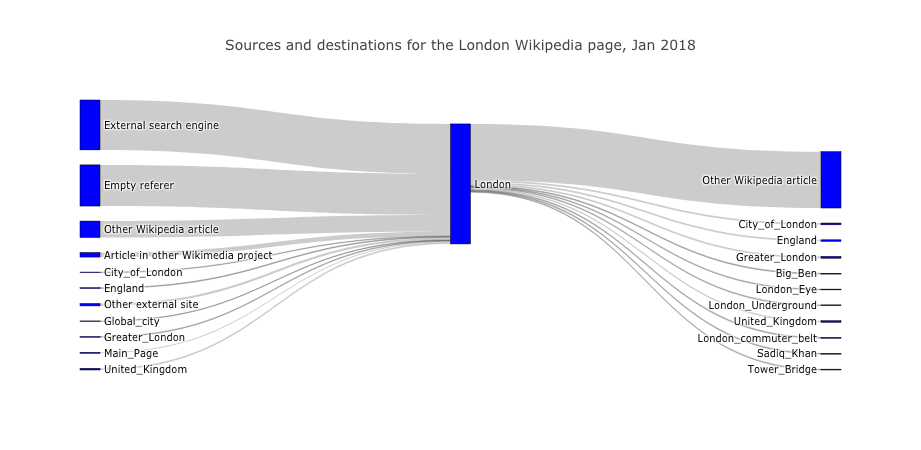

In [184]:
data = dict(
    type='sankey',
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(
        color = "black",
        width = 0.5
      ),
      label = labels,
      color = ["blue"] * len(labels)
    ),
    link = df[['source', 'target', 'value']].to_dict(orient='list')
)

layout =  dict(
    title = "Sources and destinations for the London Wikipedia page, Jan 2018",
    font = dict(
      size = 10
    )
)

fig = dict(data=[data], layout=layout)
iplot(fig)